# Importing necessary Libraries
#################### #################### #################### ####################  #################### #################### #################### #################### #################### ####################

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
%matplotlib inline
import shap
import eli5

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score,  classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn import metrics

freeze = False #Setting a global freeze variable to control whether to execute certain code blocks


# Loading the dataset and starting with basic EDA
#################### #################### #################### ####################  #################### #################### #################### #################### #################### ####################

In [2]:
# Load the dataset
data = pd.read_excel('/Users/debajyotidas/Library/CloudStorage/OneDrive-Personal/CompareTheMarket_SeniorDataScientist/CaseStudy/Case study - Data Scientist - Data.xlsx')
data.head()


,CustomerID,Age,Segment,Recency,PriorInterest,DidPurchase
0,1,56,A,Inactive,0,0
1,2,39,A,Inactive,0,0
2,3,62,A,Active,1,1
3,4,29,C,Inactive,0,0
4,5,41,C,Dormant,0,0


In [3]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   CustomerID     100000 non-null  int64 
 1   Age            100000 non-null  int64 
 2   Segment        99507 non-null   object
 3   Recency        99507 non-null   object
 4   PriorInterest  100000 non-null  int64 
 5   DidPurchase    100000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


In [4]:
data.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,100000.0,NaN,NaN,NaN,50000.5,28867.657797,1.0,25000.75,50000.5,75000.25,100000.0
Age,100000.0,NaN,NaN,NaN,38.75285,13.374228,18.0,28.0,36.0,48.0,75.0
Segment,99507,3,C,58517,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recency,99507,3,Active,55428,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PriorInterest,100000.0,NaN,NaN,NaN,0.09178,0.288717,0.0,0.0,0.0,0.0,1.0
DidPurchase,100000.0,NaN,NaN,NaN,0.3,0.45826,0.0,0.0,0.0,1.0,1.0


In [5]:
# Let's check # of unique values in each column
print("# of Unique Customers: ", data['CustomerID'].nunique())
print("# of Unique Ages: ", data['Age'].nunique())
print("# of Unique Segments: ", data['Segment'].nunique())
print("# of Unique Recency: ", data['Recency'].nunique())
print("# of Unique PriorInterest: ", data['PriorInterest'].nunique())
print("# of Unique DidPurchase: ", data['DidPurchase'].nunique())


# of Unique Customers:  100000
# of Unique Ages:  58
# of Unique Segments:  3
# of Unique Recency:  3
# of Unique PriorInterest:  2
# of Unique DidPurchase:  2


In [6]:
# Let's check the unique values in each column
print("Unique Ages: ", data['Age'].unique())
print("Unique Segments: ", data['Segment'].unique())
print("Unique Recency: ", data['Recency'].unique())
print("Unique PriorInterest: ", data['PriorInterest'].unique())
print("Unique DidPurchase: ", data['DidPurchase'].unique())


Unique Ages:  [56 39 62 29 41 53 30 44 71 40 25 42 32 65 70 46 68 33 63 37 36 66 57 69
 47 31 27 20 23 55 49 61 21 48 51 67 26 52 54 38 35 64 50 34 24 59 45 28
 22 43 74 60 73 19 58 75 72 18]
Unique Segments:  ['A' 'C' 'B' nan]
Unique Recency:  ['Inactive' 'Active' 'Dormant' nan]
Unique PriorInterest:  [0 1]
Unique DidPurchase:  [0 1]


In [7]:
# Dropping the CustomerID column as its unique across each datapoint
data.drop(columns=['CustomerID'], inplace=True)
data.head()


,Age,Segment,Recency,PriorInterest,DidPurchase
0,56,A,Inactive,0,0
1,39,A,Inactive,0,0
2,62,A,Active,1,1
3,29,C,Inactive,0,0
4,41,C,Dormant,0,0


In [ ]:
# Create 'Age-Group' column by binning 'Age' as there are many unique ages
# This will help in reducing the complexity of the model and improve interpretability
# Define age bins and labels
age_bins = [0, 18, 30, 45, 60, np.inf]
age_labels = ['<18', '18-29', '30-44', '45-59', '60+']
data['Age-Group'] = pd.cut(data['Age'], bins=age_bins, labels=age_labels, right=False)


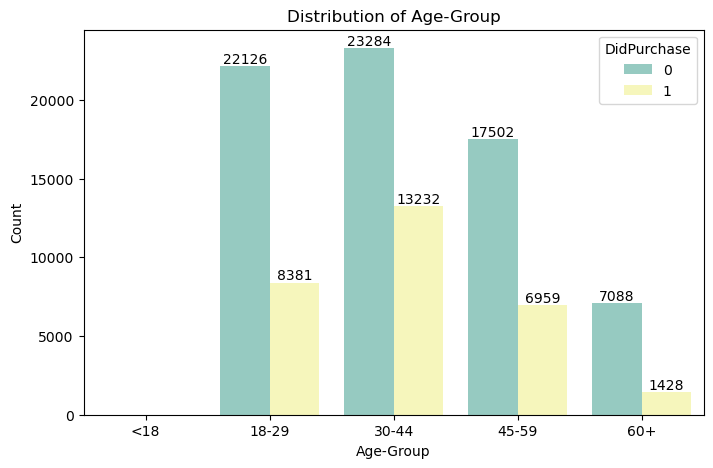

In [9]:
# Visualize the distribution of 'Age-Group'
plt.figure(figsize=(8, 5))
ax_age = sns.countplot(data=data, x='Age-Group', hue='DidPurchase', order=age_labels, palette='Set3')
plt.title('Distribution of Age-Group')
plt.xlabel('Age-Group')
plt.ylabel('Count')
for p in ax_age.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax_age.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.show()


#### 67% of the population is young (<45 years old) while 8% of the population can be assumed to be Pensioners (>60 years old).
#### 30% of the population is below 30 years old.
#### The mean age of the population is 39 years old, with the minimum age being 18 years old and the maximum age being 75 years old.
#### The median age of the population is 36 years old and standard deviation is 13.
#### The youngest 10% of the population is between 18 and 30 years old, while the oldest 10% of the population is between 60 and 75 years old.

### With these demographic insights it might be possible to make specific insurance 'type' recommendations like 'Home Insurance' for people between 30-45 years old and 'Car Insurance' to people between 18-30 years old. People above 60 years old might be more likely to need 'Life Insurance' and people between 45-60 years old might be more likely to need 'Health Insurance'.

In [10]:
data['PriorInterest'].value_counts()


0    90822
1     9178
Name: PriorInterest, dtype: int64

In [11]:
data['DidPurchase'].value_counts()


0    70000
1    30000
Name: DidPurchase, dtype: int64

### The customer base demonstrates diverse engagement patterns, with 30% (achieving purchase conversion and 9.2% showing prior product interest).

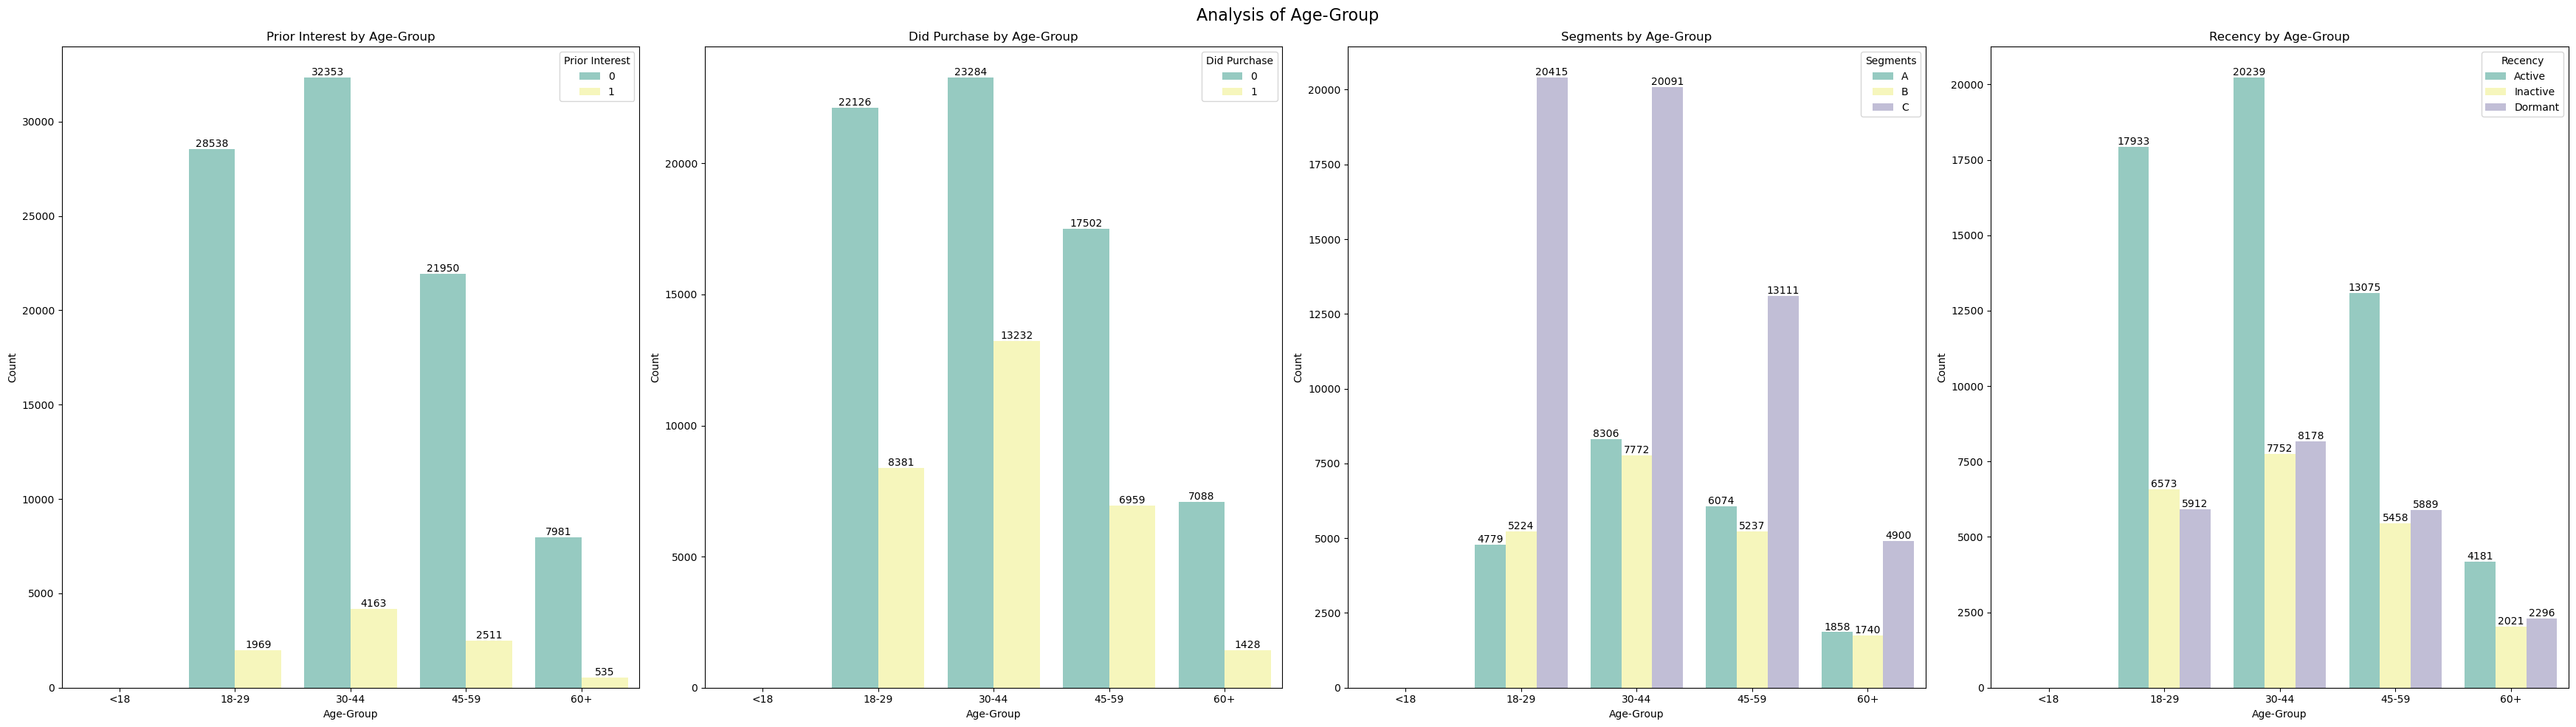

In [ ]:
# Create a figure with subplots
fig, ax = plt.subplots(1, 4, figsize=(35, 10))
plt.suptitle('Analysis of Age-Group', fontsize=16)

# Create 'Prior Interest' by 'Age-Group' plot
plt.subplot(1, 4, 1)
ax1 = sns.countplot(data=data, x='Age-Group', hue='PriorInterest', order=age_labels, palette='Set3')
plt.title('Prior Interest by Age-Group')
plt.xlabel('Age-Group')
plt.ylabel('Count')
plt.legend(title='Prior Interest')
# Annotate each bar in the Purchase plot with its count
for p in ax1.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax1.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points')

# Create Conversion by 'Age-Group' plot
plt.subplot(1, 4, 2)
ax2 = sns.countplot(data=data, x='Age-Group', hue='DidPurchase', order=age_labels, palette='Set3')
plt.title('Did Purchase by Age-Group')
plt.xlabel('Age-Group')
plt.ylabel('Count')
plt.legend(title='Did Purchase')
# Annotate each bar in the Purchase plot with its count
for p in ax2.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax2.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points')
        
# Create 'Segemnets' by 'Age-Group' plot
plt.subplot(1, 4, 3)
ax3 = sns.countplot(data=data, x='Age-Group', hue='Segment', order=age_labels, hue_order=['A', 'B', 'C'], palette='Set3')
plt.title('Segments by Age-Group')
plt.xlabel('Age-Group')
plt.ylabel('Count')
plt.legend(title='Segments')
# Annotate each bar in the Purchase plot with its count
for p in ax3.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax3.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points') 
        
# Create 'Recency' by 'Age-Group' plot
plt.subplot(1, 4, 4)
ax4 = sns.countplot(data=data, x='Age-Group', hue='Recency', order=age_labels, hue_order=['Active', 'Inactive', 'Dormant'], palette='Set3')
plt.title('Recency by Age-Group')
plt.xlabel('Age-Group')
plt.ylabel('Count')
plt.legend(title='Recency')
# Annotate each bar in the Purchase plot with its count
for p in ax4.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax4.annotate(f'{int(height)}', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points')        

plt.tight_layout()
plt.show()


### Across the age-groups, customers in the 30-44 age group express the highest interest in the product,but this can also be true since they are by far the largest age group. But interestingly, they also display the highest conversion rate, which makes them a lucrative target group to consider for the marketing campaign. Segment-wise, while segment C dominates across all age groups, segment A shows an overall higher proportion in the 30-44 age group, as compared to other age groups, which makes them an even more potential marketing target, possibly with more personalized marketing. Lastly, they are also the most 'Active' customers, which is a good sign for the company to consider for the marketing campaign.

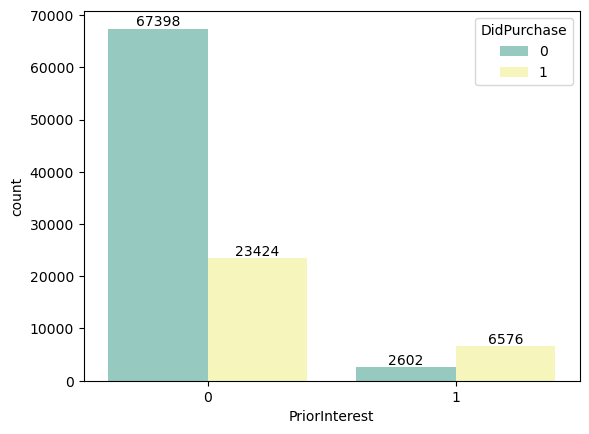

In [13]:
# Create a countplot for 'PriorInterest' vs 'DidPurchase'
ax = sns.countplot(data=data, x='PriorInterest', hue='DidPurchase', palette='Set3')
# Annotate each bar with its count
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5), textcoords='offset points')


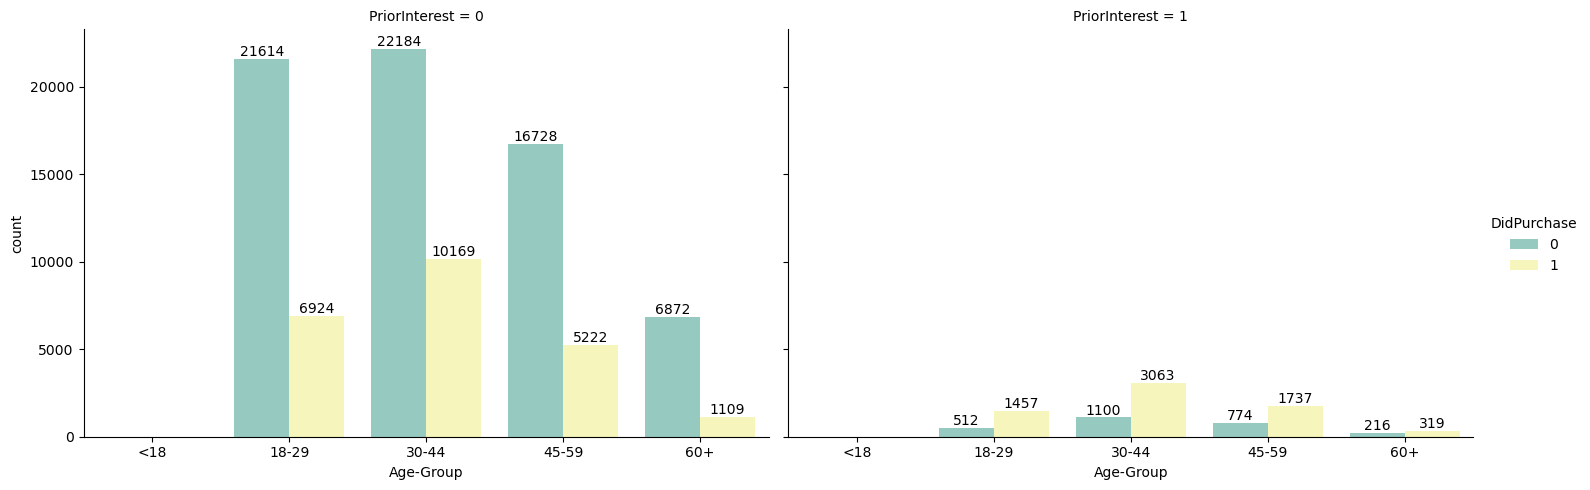

In [14]:
# Create a catplot for 'Age-Group' by 'DidPurchase' and 'PriorInterest'
g = sns.catplot(data=data, x='Age-Group', hue='DidPurchase', col='PriorInterest', kind='count', palette='Set3', col_wrap=2, height=5, aspect=1.5, legend='auto', legend_out=True)
# Annotate each bar with its count
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center',
                        xytext=(0, 5), textcoords='offset points')


### Prior product interest increases conversion by 2.8x (71.6% vs 25.8%) and becomes as high as 3.8x when the customer is aged 60+

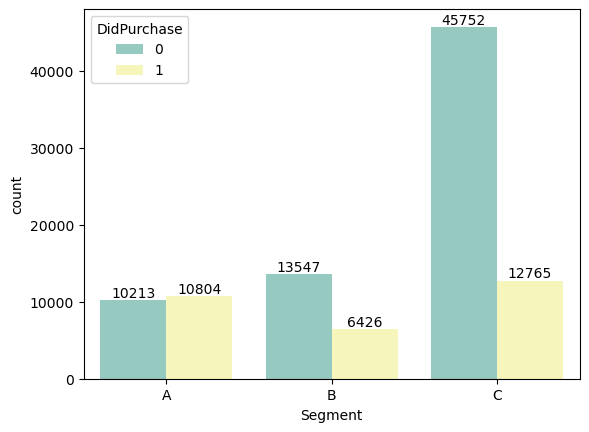

In [15]:
# Create a countplot for 'Segment' vs 'DidPurchase'
ax = sns.countplot(data=data, x='Segment', hue='DidPurchase', palette='Set3', order=['A', 'B', 'C'])
# Annotate each bar with its count
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5), textcoords='offset points')


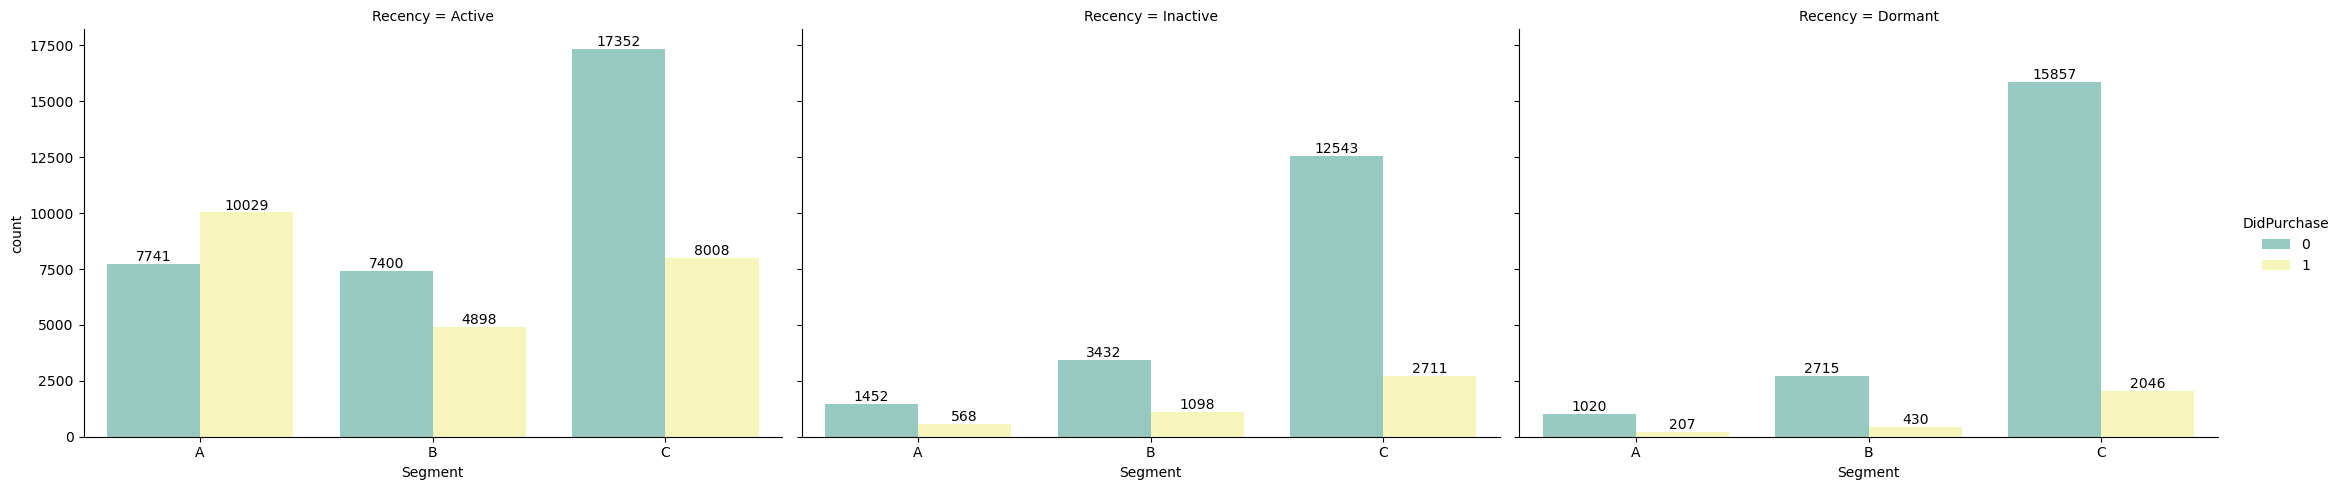

In [16]:
# Create a catplot for 'Segment' by 'DidPurchase' and 'Recency'
g = sns.catplot(data=data, x='Segment', hue='DidPurchase', col='Recency', kind='count', palette='Set3', col_wrap=3, height=5, aspect=1.5, legend='auto', legend_out=True, order=['A', 'B', 'C'], col_order=['Active', 'Inactive', 'Dormant'])
# Annotate each bar with its count
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center',
                        xytext=(0, 5), textcoords='offset points')


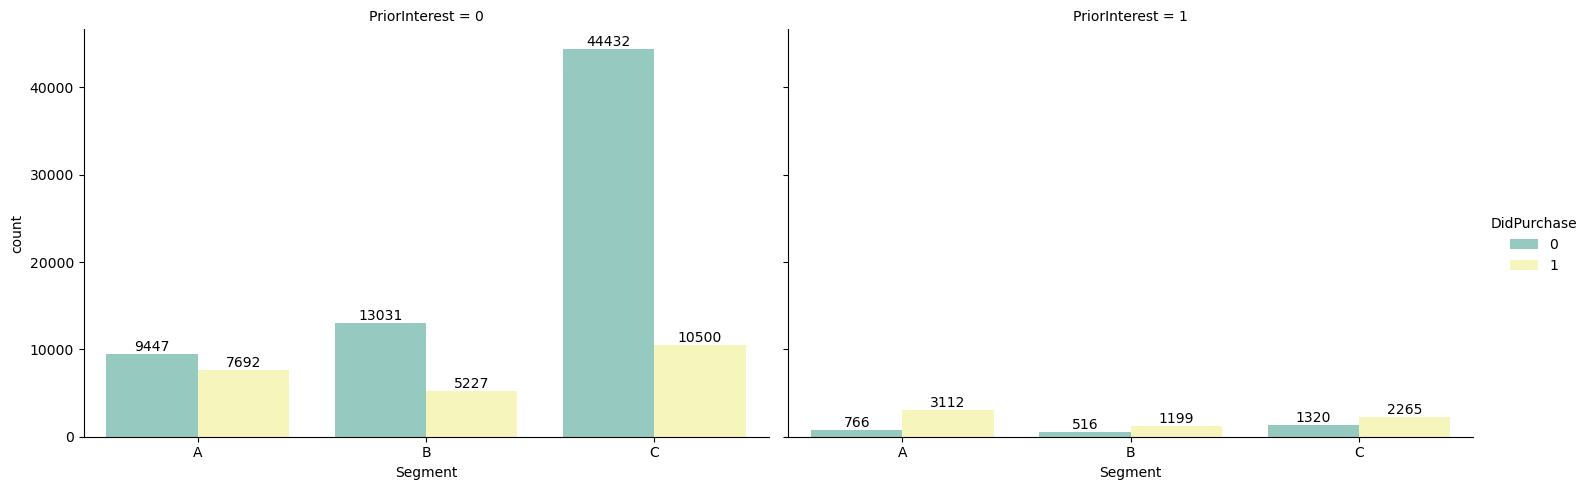

In [17]:
# Create a catplot for 'Segment' by 'DidPurchase' and 'PriorInterest'
g = sns.catplot(data=data, x='Segment', hue='DidPurchase', col='PriorInterest', kind='count', palette='Set3', col_wrap=2, height=5, aspect=1.5, legend='auto', legend_out=True, order=['A', 'B', 'C'])
# Annotate each bar with its count
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center',
                        xytext=(0, 5), textcoords='offset points')


### Having PriorInterest in the Real World definitely helps in conversion, but the rate is significantly higher for customers in Segment 'A', than in Segment 'C'. This remains true even if we factor in Recency.

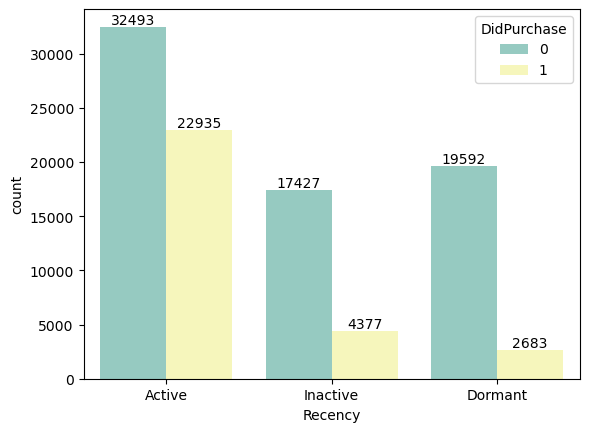

In [18]:
# Create a countplot for 'Segment' vs 'DidPurchase'
ax = sns.countplot(data=data, x='Recency', hue='DidPurchase', palette='Set3', order=['Active', 'Inactive', 'Dormant'])
# Annotate each bar with its count
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 5), textcoords='offset points')


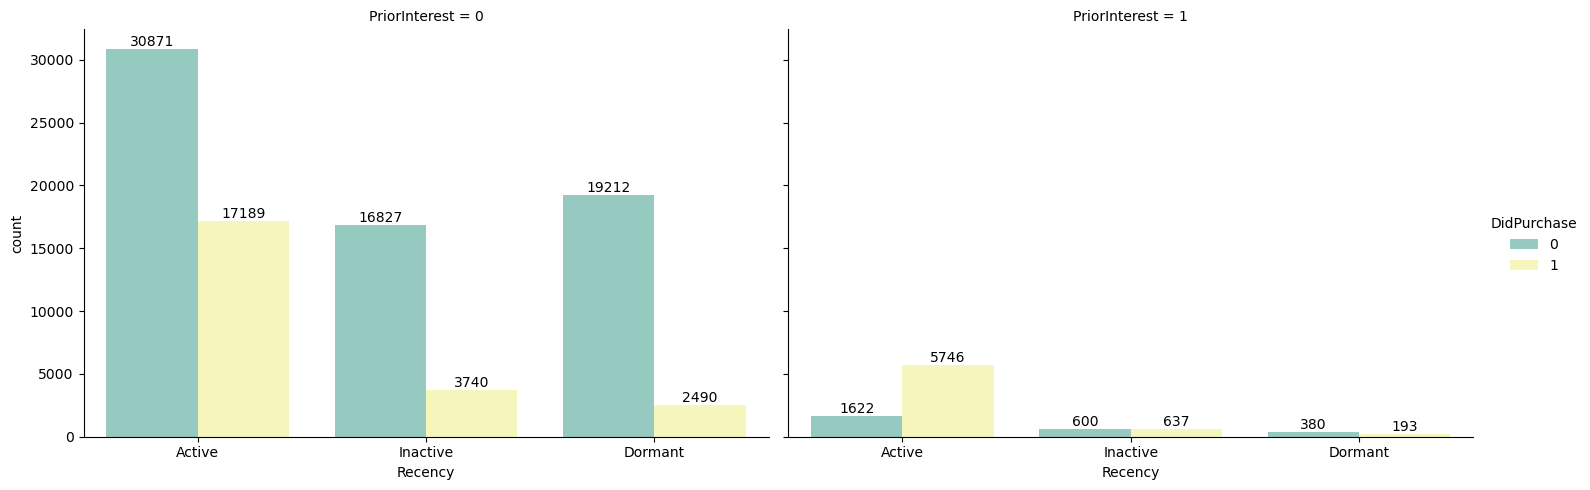

In [19]:
# Create a catplot for 'Segment' by 'DidPurchase' and 'PriorInterest'
g = sns.catplot(data=data, x='Recency', hue='DidPurchase', col='PriorInterest', kind='count', palette='Set3', col_wrap=2, height=5, aspect=1.5, legend='auto', legend_out=True, order=['Active', 'Inactive', 'Dormant'],orient='v')
# Annotate each bar with its count
for ax in g.axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center',
                        xytext=(0, 5), textcoords='offset points')


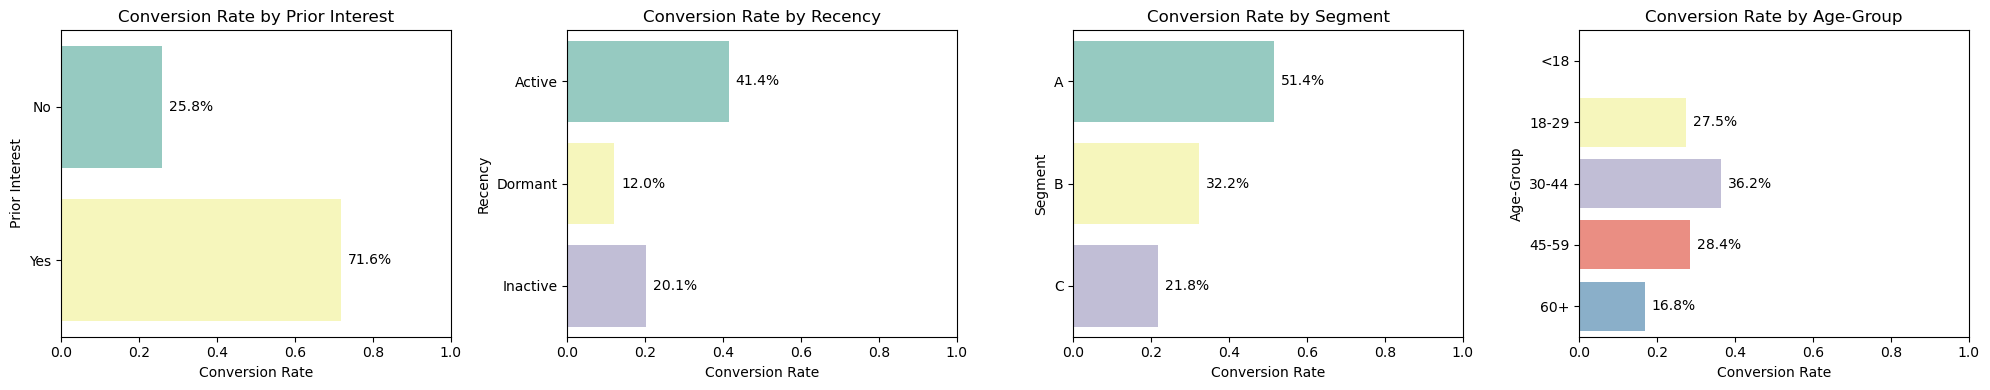

In [20]:
plt.figure(figsize=(20, 4))

# Create a plot of Conversion Rate by Prior Interest
plt.subplot(1, 4, 1)
# Calculate conversion rate by PriorInterest
conversion_rate = data.groupby('PriorInterest', as_index=False)['DidPurchase'].mean()
# Map PriorInterest values to 'Yes' and 'No' labels
conversion_rate['PriorInterestLabel'] = conversion_rate['PriorInterest'].map({1: 'Yes', 0: 'No'})
ax = sns.barplot(data=conversion_rate,x='DidPurchase',y='PriorInterestLabel',orient='h', palette='Set3')
plt.title('Conversion Rate by Prior Interest')
plt.xlabel('Conversion Rate')
plt.ylabel('Prior Interest')
plt.xlim(0, 1)
# Annotate each bar with the percentage value
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{width:.1%}', (width, y), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

# Create a plot of Conversion Rate by Recency
plt.subplot(1, 4, 2)
# Calculate conversion rate by Recency
conversion_rate_recency = data.groupby('Recency', as_index=False)['DidPurchase'].mean()
conversion_rate_recency['Recency'] = conversion_rate_recency['Recency'].astype(str)
ax = sns.barplot(data=conversion_rate_recency, x='DidPurchase', y='Recency', orient='h', palette='Set3')
plt.title('Conversion Rate by Recency')
plt.xlabel('Conversion Rate')
plt.ylabel('Recency')
plt.xlim(0, 1)
# Annotate each bar with the percentage value
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{width:.1%}', (width, y), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

# Create a plot of Conversion Rate by Segment
plt.subplot(1, 4, 3)
# Calculate conversion rate by Segment
conversion_rate_segment = data.groupby('Segment', as_index=False)['DidPurchase'].mean()
conversion_rate_segment['Segment'] = conversion_rate_segment['Segment'].astype(str)
ax = sns.barplot(data=conversion_rate_segment, x='DidPurchase', y='Segment', orient='h', palette='Set3')
plt.title('Conversion Rate by Segment')
plt.xlabel('Conversion Rate')
plt.ylabel('Segment')
plt.xlim(0, 1)
# Annotate each bar with the percentage value
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{width:.1%}', (width, y), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

# Create a plot of Conversion Rate by Age-Group
plt.subplot(1, 4, 4)
# Calculate conversion rate by Age-Group
conversion_rate_segment = data.groupby('Age-Group', as_index=False)['DidPurchase'].mean()
conversion_rate_segment['Age-Group'] = conversion_rate_segment['Age-Group'].astype(str)
ax = sns.barplot(data=conversion_rate_segment, x='DidPurchase', y='Age-Group', orient='h', palette='Set3')
plt.title('Conversion Rate by Age-Group')
plt.xlabel('Conversion Rate')
plt.ylabel('Age-Group')
plt.xlim(0, 1)
# Annotate each bar with the percentage value
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{width:.1%}', (width, y), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()


### Observing Conversion Rates across the different available features gives a nice visual intuition as to what can be the most significant drivers for successful conversions.

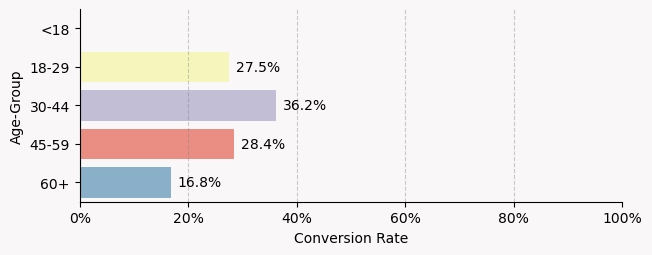

In [21]:
# Calculate conversion rate by Segment
conversion_rate = data.groupby('Age-Group', as_index=False)['DidPurchase'].mean()

fig, ax = plt.subplots(figsize=(7, 2.5), facecolor='#faf7f9')
# Professional contrasting background
ax.set_facecolor("#faf7f9")

# Barplot with no external borders
sns.barplot(data=conversion_rate,x='DidPurchase',y='Age-Group',orient='h',palette='Set3',ax=ax,edgecolor=None, order=['<18', '18-29', '30-44', '45-59', '60+'])


# Remove top and right spines (external borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add gridlines for x-axis
ax.xaxis.grid(True, linestyle='--', color='gray', alpha=0.4)

# Format x-axis as percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel('Conversion Rate')
plt.ylabel('Age-Group')
plt.xlim(0, 1)

# Annotate each bar with the percentage value
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{width:.1%}', (width, y), ha='left', va='center', xytext=(5, 0), textcoords='offset points')


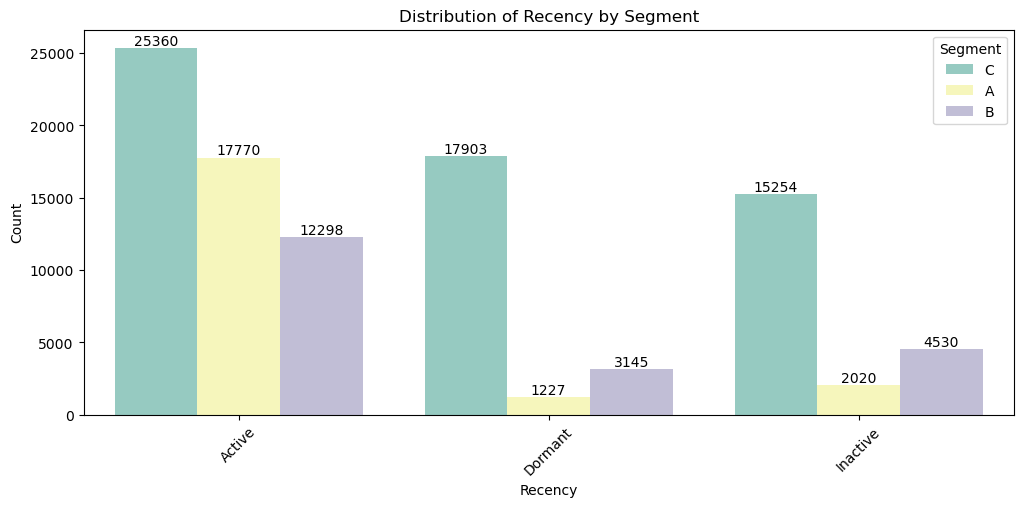

In [22]:

# Get sorted unique values for 'Recency' and 'Segment' columns to define plotting order
recency_order = data['Recency'].value_counts().sort_values(ascending=False).index.tolist()
segment_order = data['Segment'].value_counts().sort_values(ascending=False).index.tolist()

#Create a count plot of 'Recency' by 'Segment'
plt.figure(figsize=(12, 5))
ax1 = sns.countplot(data=data, x='Recency', hue='Segment', order=recency_order, hue_order=segment_order, palette='Set3')
plt.title('Distribution of Recency by Segment')
plt.xticks(rotation=45)
# Annotate each bar in the Recency plot with its count
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    xytext=(0, 5), textcoords='offset points')
plt.xlabel('Recency')
plt.ylabel('Count')
plt.legend(title='Segment')
plt.show()


# Building Customer Personas
#################### #################### #################### ####################  #################### #################### #################### #################### #################### ####################

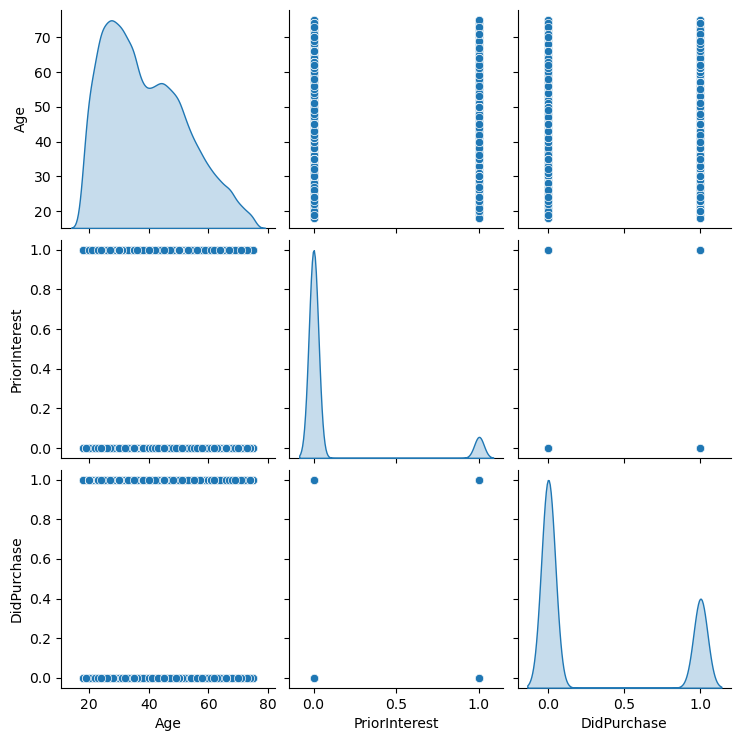

In [23]:
sns.pairplot(data,diag_kind='kde')


In [ ]:
# Generating an encoded version of the dataset for clustering
# This will convert categorical variables into a format suitable for clustering and for later modelling activities
# We will use one-hot encoding for categorical variables and drop the first category to avoid multicollinearity
# The columns 'Age-Group', 'PriorInterest', 'Segment', and 'Recency' are categorical variables, while 'DidPurchase' is the target variable and will not be included in the clustering process
data_encoded = pd.get_dummies(data, columns=['Age-Group', 'PriorInterest', 'Segment', 'Recency'], drop_first=True)


In [25]:
distortion=[]
# Let us check optimal number of clusters-
cluster_range = range(2,10) #Based on the class distribution, our classes would be between 2-10
cluster_errors = []
cluster_sil_scores = []
for num_clusters in cluster_range:
  clusters = KMeans(num_clusters,random_state=1)
  clusters.fit(data_encoded)
  labels = clusters.labels_                   # capture the cluster lables
  centroids = clusters.cluster_centers_       # capture the centroids
  cluster_errors.append( clusters.inertia_ )  # capture the intertia
  distortion.append(sum(np.min(distance.cdist(data_encoded, clusters.cluster_centers_, 'euclidean'), axis=1))/ data_encoded.shape[0])
  cluster_sil_scores.append(metrics.silhouette_score(data_encoded, labels, metric='euclidean'))
    
# combine the cluster_range and cluster_errors into a dataframe by combining them
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors,"distortion":distortion,"avg_sil_scores":cluster_sil_scores} )
clusters_df[0:15]


,num_clusters,cluster_errors,distortion,avg_sil_scores
0,2,5.203191e+06,6.101650,0.606808
1,3,2.658996e+06,4.497578,0.543129
2,4,1.567980e+06,3.502827,0.525926
3,5,1.066247e+06,2.865327,0.499218
4,6,8.179597e+05,2.595191,0.491907
5,7,6.211966e+05,2.264044,0.470846
6,8,5.401880e+05,2.049484,0.438610
7,9,4.185344e+05,1.895585,0.430726


Text(0, 0.5, 'Distortion')

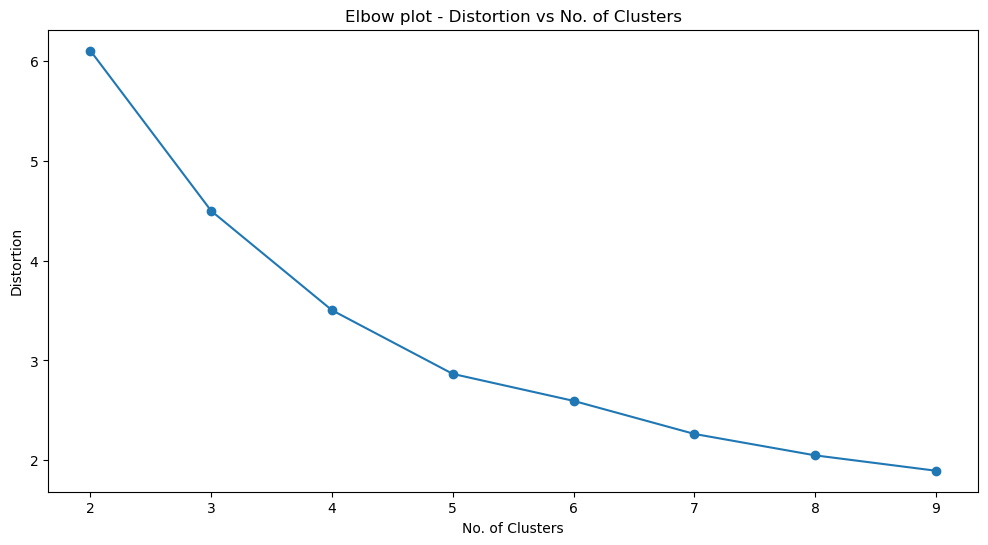

In [26]:
# Elbow plot
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.distortion, marker = "o" )
plt.title('Elbow plot - Distortion vs No. of Clusters')
plt.xlabel('No. of Clusters')
plt.ylabel('Distortion')


### In this plot, the elbow appears around 4–5 clusters, suggesting that segmenting customers into 4 or 5 groups captures most of the structure in the data without overfitting.

**Business implication:**  
Choosing the number of clusters at the elbow helps create meaningful customer segments that are distinct, interpretable, and actionable for targeted marketing or personalization.

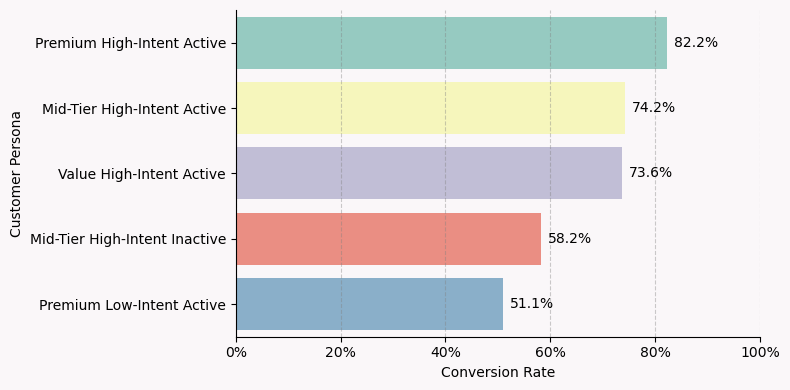

In [27]:
# Calculate conversion rate by Segment, Recency, and PriorInterest
conversion_grouped = (data.groupby(['Segment', 'Recency', 'PriorInterest'], as_index=False)['DidPurchase'].mean().rename(columns={'DidPurchase': 'ConversionRate'}))

# Create a combined label for each group
conversion_grouped['Group'] = (conversion_grouped['Segment'].astype(str) + ' | ' + conversion_grouped['Recency'].astype(str) + ' | ' + conversion_grouped['PriorInterest'].map({0: 'No Prior', 1: 'Prior'}))

# Sort by conversion rate descending
conversion_grouped = conversion_grouped.sort_values('ConversionRate', ascending=False)

# Select top-5 conversion rates and assign custom labels
top5 = conversion_grouped.head(5).copy()
custom_labels = ['Premium High-Intent Active',
                 'Mid-Tier High-Intent Active',
                 'Value High-Intent Active',
                 'Mid-Tier High-Intent Inactive',
                 'Premium Low-Intent Active']
top5['CustomLabel'] = custom_labels

# Plot
fig, ax = plt.subplots(figsize=(8, 4), facecolor='#faf7f9')
ax.set_facecolor("#faf7f9")
sns.barplot(data=top5, x='ConversionRate', y='CustomLabel', orient='h', palette='Set3', ax=ax, edgecolor=None)

# Remove top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add vertical gridlines
ax.xaxis.grid(True, linestyle='--', color='gray', alpha=0.4)

# Format x-axis as percentage
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.xlabel('Conversion Rate')
plt.ylabel('Customer Persona')
plt.xlim(0, 1)

for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{width:.1%}', (width, y), ha='left', va='center', xytext=(5, 0), textcoords='offset points')

plt.tight_layout()
plt.show()


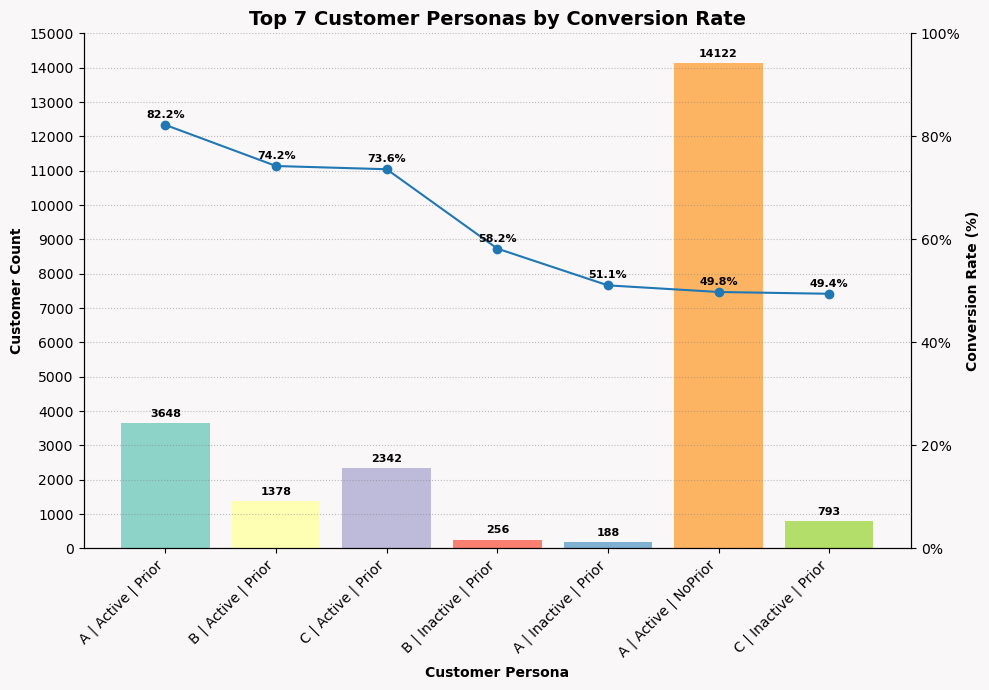

In [28]:
# Create a combined segment label including 'Segment', 'Recency', and 'PriorInterest'
data['CombinedSegment'] = (data['Segment'].astype(str) + ' | ' + data['Recency'].astype(str) + ' | ' + data['PriorInterest'].map({0: 'NoPrior', 1: 'Prior'}))

# Group by the combined segment and calculate customer count and conversion rate
segment_stats_no_age = data.groupby('CombinedSegment').agg(CustomerCount=('DidPurchase', 'size'),ConversionRate=('DidPurchase', 'mean'),Segment=('Segment', 'first')).reset_index()

# Remove rows with missing Segment before categorization and sorting
segment_stats_no_age = segment_stats_no_age[segment_stats_no_age['Segment'].notnull()].copy()
segment_stats_no_age['Segment'] = pd.Categorical(segment_stats_no_age['Segment'], categories=segment_order, ordered=True)

# Select top-7 personas by conversion rate
top7 = segment_stats_no_age.sort_values('ConversionRate', ascending=False).head(7)

# Use seaborn color palette for bar colors
bar_colors = sns.color_palette('Set3', n_colors=len(top7))

fig, ax1 = plt.subplots(figsize=(10, 7), facecolor='#faf7f9')
ax1.set_facecolor("#faf7f9")
ax1.set_title('Top 7 Customer Personas by Conversion Rate', fontweight='bold', fontsize=14, color='#000000')

# Plot
bar = ax1.bar(top7['CombinedSegment'], top7['CustomerCount'], color=bar_colors, label='Customer Count')
ax1.set_ylabel('Customer Count', fontweight='bold')
ax1.set_xlabel('Customer Persona', fontweight='bold')
ax1.tick_params(axis='y')
ax1.set_xticks(range(len(top7)))
ax1.set_xticklabels(top7['CombinedSegment'], rotation=45, ha='right', fontsize=10)
ax1.set_yticks(np.linspace(0, 15000, num=16, endpoint=True))

# Add horizontal gridlines for primary y-axis
ax1.yaxis.grid(True, linestyle='dotted', color='gray', alpha=0.5)

# Secondary axis for conversion rate as %
ax2 = ax1.twinx()
ax2.plot(range(len(top7)), top7['ConversionRate'], marker='o', label='Conversion Rate')
ax2.set_ylabel('Conversion Rate (%)', fontweight='bold')
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Remove the top spines (borders) across both axes
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Annotate bars with counts
for rect in bar:
    height = rect.get_height()
    if height > 0:
        ax1.annotate(f'{int(height)}', 
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3), 
                     textcoords="offset points", 
                     ha='center', 
                     va='bottom',
                     fontweight='bold',
                     fontsize=8)

# Annotate conversion rate points
for i, rate in enumerate(top7['ConversionRate']):
    ax2.annotate(f'{rate:.1%}', 
                 (i, rate), 
                 textcoords="offset points", 
                 xytext=(0, 5), 
                 ha='center', 
                 fontweight='bold',
                 fontsize=8)
    
fig.tight_layout()
plt.show()


# Propensity Modelling 
#################### #################### #################### ####################  #################### #################### #################### #################### #################### ####################

### With some assumptions, let us try and perform a basic propensity modelling of the data with whatever available features we have.
#### We will be using a baseline model of logistic regression with a single feature ('PriorInterest') to understand how it can help in potentially uplifting the conversion rate.

In [29]:
data = data.drop(columns=['CombinedSegment'])

# Split treatment (PriorInterest=1) and control (PriorInterest=0)
treatment = data[data['PriorInterest'] == 1].copy()
control = data[data['PriorInterest'] == 0].copy()

# Convert categorical features: 'Age-Group', 'Segment', 'Recency'; to dummy variables
treatment = pd.get_dummies(treatment, columns=['Age-Group', 'Segment', 'Recency'], drop_first=True)
control = pd.get_dummies(control, columns=['Age-Group', 'Segment', 'Recency'], drop_first=True)

# Dropping the 'Age' column as it is not needed for modeling and as we have already created 'Age-Group'
treatment = treatment.drop(columns=['Age'], axis=1)
control = control.drop(columns=['Age'], axis=1)

# Align columns
treatment, control = treatment.align(control, join='inner', axis=1)

# Split into train/test
treat_train, treat_test = train_test_split(treatment, test_size=0.3, random_state=42)
ctrl_train, ctrl_test = train_test_split(control, test_size=0.3, random_state=42)

# Define and train separate models
treat_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced',max_iter=1000)
ctrl_model  = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced',max_iter=1000)

treat_model.fit(treat_train.drop(columns = ['DidPurchase'], axis=1), treat_train['DidPurchase'])
ctrl_model.fit(ctrl_train.drop(columns = ['DidPurchase'], axis=1), ctrl_train['DidPurchase'])

# Applying models to whole dataset for uplift scoring
df_model = pd.get_dummies(data, columns=['Age-Group', 'Segment', 'Recency'], drop_first=True)
df_model = df_model.reindex(columns=treat_train.drop('DidPurchase', axis=1).columns, fill_value=0)

# Predicting probabilities
data_uplift = data.copy()
data_uplift['P_treatment'] = treat_model.predict_proba(df_model)[:, 1]
data_uplift['P_control'] = ctrl_model.predict_proba(df_model)[:, 1]

# Calculating uplift
data_uplift['uplift_score'] = data_uplift['P_treatment'] - data_uplift['P_control']

# Ranking customers by uplift score
df_sorted = data_uplift.sort_values(by='uplift_score', ascending=False)

# Classifying the customers based P_treatment and P_control probabilities
df_sorted['uplift_class'] = 'Others'

# Defining top 20% of customers as 'Persuadable'
# This is a common practice in uplift modeling to focus on the most promising customers
top_20pct_cutoff = int(0.2 * len(df_sorted))    #defining top 20% cutoff
df_sorted.iloc[:top_20pct_cutoff, df_sorted.columns.get_loc('uplift_class')] = 'Persuadable'

# Classifying the rest of the customers based on their P_treatment and P_control probabilities
df_sorted.loc[(df_sorted['P_treatment'] > 0.5) & (df_sorted['P_control'] > 0.5) & (df_sorted['uplift_class'] == 'Others'), 'uplift_class'] = 'Sure Thing'
df_sorted.loc[(df_sorted['P_treatment'] < 0.5) & (df_sorted['P_control'] > 0.5) & (df_sorted['uplift_class'] == 'Others'), 'uplift_class'] = 'Do Not Disturb'
df_sorted.loc[(df_sorted['P_treatment'] < 0.5) & (df_sorted['P_control'] < 0.5) & (df_sorted['uplift_class'] == 'Others'), 'uplift_class'] = 'Lost Cause'

# Display Value counts
print(df_sorted['uplift_class'].value_counts())


Lost Cause        40181
Sure Thing        24474
Persuadable       20000
Do Not Disturb    15345
Name: uplift_class, dtype: int64


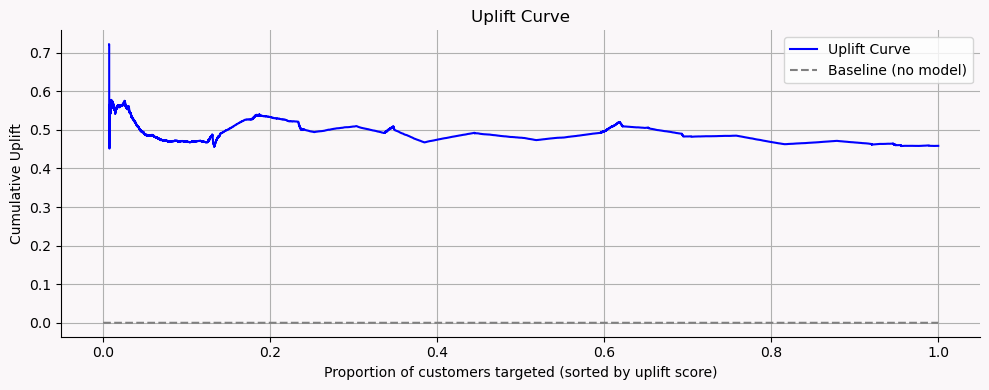

In [30]:
# Visualize the uplift curve

# Sort by uplift score (descending)
df_sorted = data_uplift.sort_values(by='uplift_score', ascending=False).reset_index(drop=True)

# Create binary flags
df_sorted['treatment'] = df_sorted['PriorInterest']
df_sorted['outcome'] = df_sorted['DidPurchase']

# Create cumulative treatment and outcome
df_sorted['cum_treat'] = df_sorted['treatment'].cumsum()
df_sorted['cum_ctrl'] = (~df_sorted['treatment'].astype(bool)).cumsum()

df_sorted['cum_outcome_treat'] = (df_sorted['outcome'] * df_sorted['treatment']).cumsum()
df_sorted['cum_outcome_ctrl'] = (df_sorted['outcome'] * (1 - df_sorted['treatment'])).cumsum()

# To avoid divide-by-zero
df_sorted['rate_treat'] = df_sorted['cum_outcome_treat'] / df_sorted['cum_treat'].replace(0, np.nan)
df_sorted['rate_ctrl'] = df_sorted['cum_outcome_ctrl'] / df_sorted['cum_ctrl'].replace(0, np.nan)

# Uplift at each point
df_sorted['uplift'] = df_sorted['rate_treat'] - df_sorted['rate_ctrl']

# Plot uplift curve
x = np.arange(1, len(df_sorted) + 1) / len(df_sorted)
y = df_sorted['uplift']

fig, ax = plt.subplots(figsize=(10, 4), facecolor='#faf7f9')
ax.set_facecolor("#faf7f9")
ax.plot(x, y, label='Uplift Curve', color='blue')
ax.plot(x, [0]*len(x), '--', label='Baseline (no model)', color='gray')
ax.set_title('Uplift Curve')
ax.set_xlabel('Proportion of customers targeted (sorted by uplift score)')
ax.set_ylabel('Cumulative Uplift')
ax.legend()
ax.grid(True)
# Remove top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


### Uplift Modeling
#### The uplift curve shows that targeting customers based on the uplift model yields a positive incremental effect compared to random targeting, but the overall uplift is modest and mostly flat
#### This indicates limited differentiation between treatment and control groups

# Customer Lifetime Value (CLV) 
#################### #################### #################### ####################  #################### #################### #################### #################### #################### ####################

## Below we create a proxy Customer Lifetime Value (CLV) entity with the following parameters:
- **Expected Purchase Value**: assumed to be flat 100 
- **Expected Purchase Frequency**: derived from ‘Segment’, ‘Prior Interest’, & ‘Recency’
- **Expected Tenure / Retention**: derived from ‘Age’, ‘Recency’, & ‘Prior Interest’
### The CLV is calculated using the formula:
- CLV = Expected Purchase Value x Expected Purchase Frequency x Expected Tenure / Retention


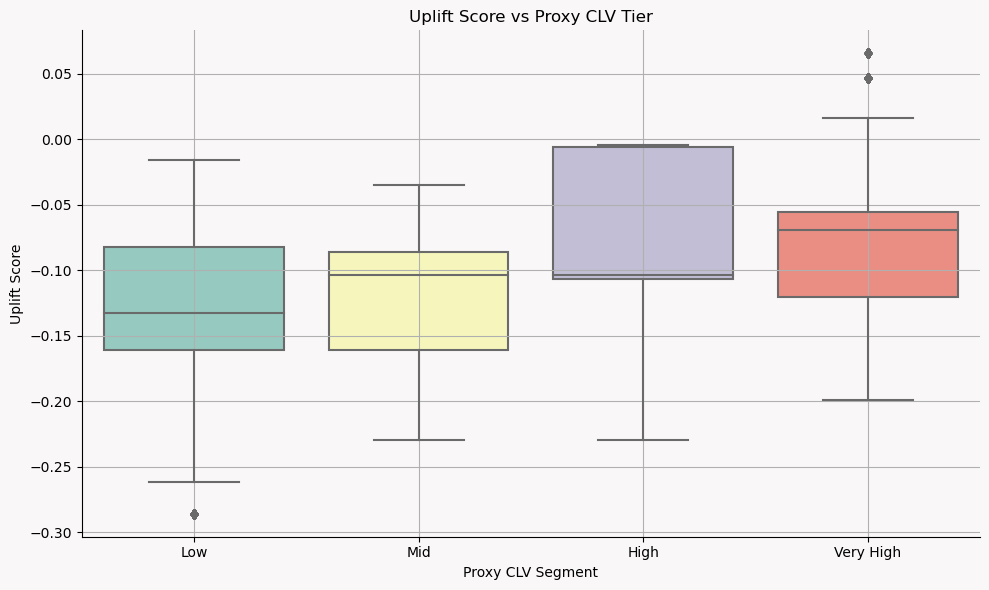

In [31]:
df_clv = data_uplift.copy()

# One-hot encode Segment
df_clv = pd.get_dummies(df_clv, columns=['Segment', 'Age-Group'], drop_first=True)

# Convert Recency and PriorInterest to numerical values
# 'Recency' is categorical with values like 'Active', 'Inactive', 'Dormant' while 'PriorInterest' is binary (0 or 1)
# Encoding Recency and PriorInterest
labelencoder = LabelEncoder()
df_clv['Recency'] = labelencoder.fit_transform(df_clv['Recency'])
df_clv['PriorInterest'] = labelencoder.fit_transform(df_clv['PriorInterest'])

# Normalize Age
scaler = MinMaxScaler()
df_clv[['Age']] = scaler.fit_transform(df_clv[['Age']])

# Engagement Score: customers who visited recently and had prior interest
df_clv['engagement_score'] = (0.6 * (1 - df_clv['Recency']) +   # more recent = higher score
                              0.4 * df_clv['PriorInterest'])     # prior interest = higher engagement

# Retention Proxy: assume older customers and recent visitors are more likely to stay
df_clv['retention_score'] = (0.5 * df_clv['Age'] + 
                             0.3 * (1 - df_clv['Recency']) + 
                             0.2 * df_clv['PriorInterest'])

# Frequency Proxy: Segment-based assumptions
segment_weights = {'Segment_A': 1.2,  # more likely to engage repeatedly
                   'Segment_B': 1.0,
                   'Segment_C': 0.7}

# Create weighted frequency score
df_clv['frequency_score'] = (df_clv.get('Segment_A', 0) * segment_weights['Segment_A'] +
                             df_clv.get('Segment_B', 0) * segment_weights['Segment_B'] +
                             df_clv.get('Segment_C', 0) * segment_weights['Segment_C'])

AOV = 100  # constant

df_clv['proxy_clv'] = AOV * df_clv['frequency_score'] * df_clv['retention_score']
df_clv['proxy_clv_norm'] = df_clv['proxy_clv'] / df_clv['proxy_clv'].max()
df_clv['CLV_Tier'] = pd.qcut(df_clv['proxy_clv'], q=4, labels=['Low', 'Mid', 'High', 'Very High'])

fig, ax = plt.subplots(figsize=(10, 6), facecolor='#faf7f9')
ax.set_facecolor("#faf7f9")
ax = sns.boxplot(data=df_clv, x='CLV_Tier', y='uplift_score', palette='Set3')
ax.set_title("Uplift Score vs Proxy CLV Tier")
ax.set_xlabel("Proxy CLV Segment")
ax.set_ylabel("Uplift Score")
ax.grid(True)

# Remove top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


### The generated plot shows the distribution of **uplift scores** across different **proxy CLV (Customer Lifetime Value) tiers**.

- **X-axis:** Proxy CLV Segment (Low, Mid, High, Very High) — customers are grouped into four tiers based on their estimated lifetime value.
- **Y-axis:** Uplift Score — this measures how much more likely a customer is to purchase if targeted (treatment) versus not targeted (control), as predicted by our earlier uplift model.

**How to interpret:**
- Each box shows the spread (distribution) of uplift scores for customers in that CLV tier.
    • The middle line in each box shows the typical (median) uplift score for that group.
    • If a tier has a higher median uplift score, it means customers in that group are more likely to respond positively to marketing/treatment.
- The whiskers and dots show the range and any unusual cases (outliers).
    • Outliers and the spread indicate variability within each tier.

**Key Implications:**
 - All segments have negative median uplift scores: This suggests that, on average, the current strategy or campaign may not be delivering positive incremental value for any customer value tier.
 - “High” and “Very High” value customers have uplift scores closer to zero: These groups are less negatively impacted, or potentially benefit more from the strategy compared to “Low” and “Mid” value customers.
 - “Low” and “Mid” segments show more negative uplift: The strategy may be less effective—or even counterproductive—for these lower-value customers.
 - Spread and outliers: There’s considerable variation within each group, especially among “High” and “Very High” value customers, indicating that some individuals respond better (or worse) than the average.

**Why this is useful:**
- The plots help us identify which CLV segments contain the most "persuadable" customers (high uplift).
- Targeting high-CLV, high-uplift customers can maximize marketing ROI.
- If low-CLV tiers have low or negative uplift, we may want to deprioritize them for campaigns.

**Business Takeaways:**
 - We need to re-evaluate our approach for lower-value customers: The strategy may need to be adjusted, as it could be having an adverse effect on them.
 - Potential in higher-value segments: While not strongly positive, “High” and “Very High” customers show signs that the strategy could be refined to unlock more value.
 - Personalisation opportunity: We can consider segmenting our approach further, tailoring campaigns or offers to different value tiers to improve uplift—especially for our most valuable customers.

### In summary:  
    The plot helps us see how the predicted marketing impact (uplift) varies by customer value, guiding smarter targeting decisions.

# Correlation Summary
#################### #################### #################### ####################  #################### #################### #################### #################### #################### ####################

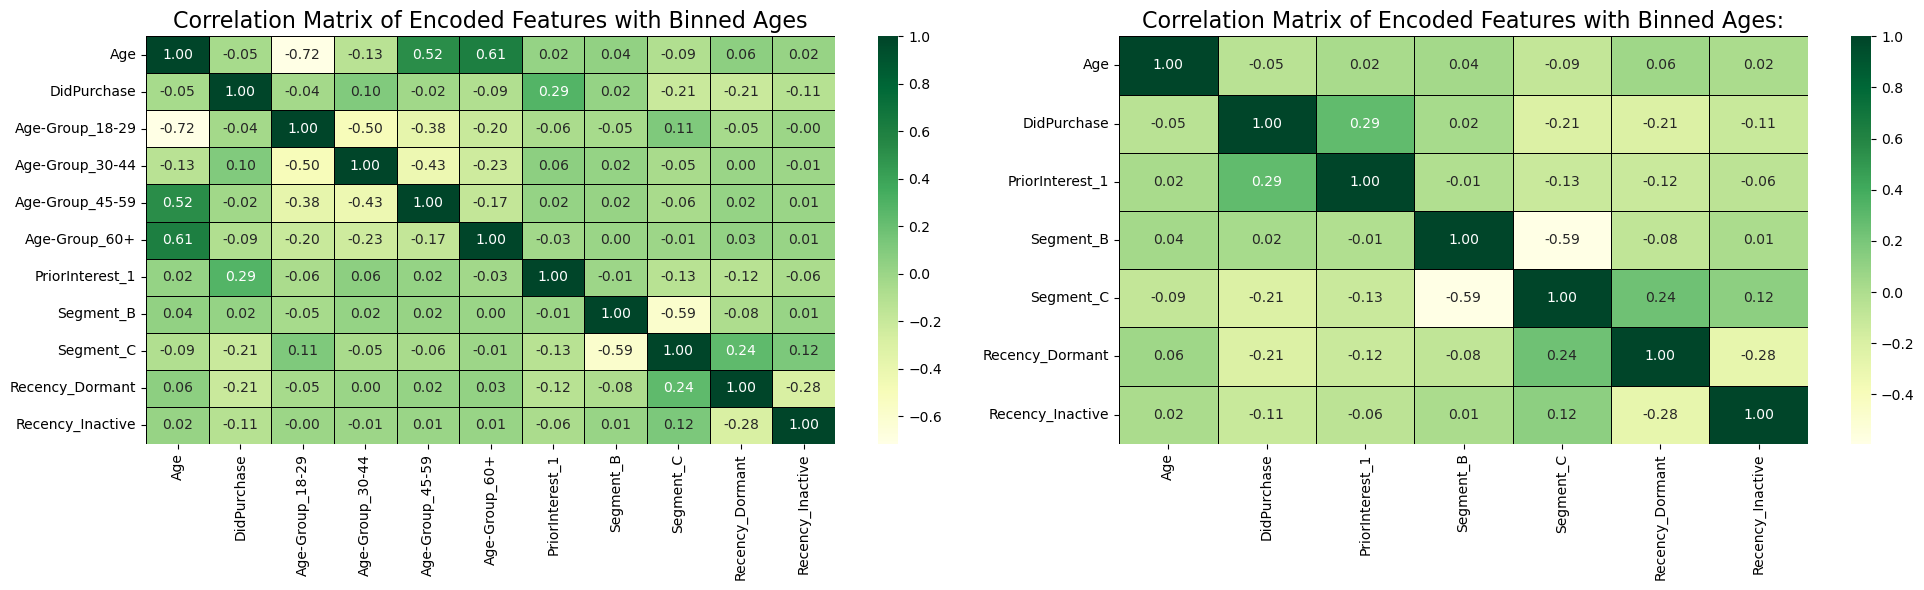

In [ ]:
plt.figure(figsize=(20, 6))
# Create a heatmap of the correlation matrix for the encoded features with binned ages
plt.subplot(1, 2, 1)
ax = sns.heatmap(data_encoded.corr(numeric_only=False), annot=True, cmap='YlGn' , fmt='.2f', linewidths=0.5, linecolor='black')
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_bottom()
plt.xticks(rotation=90)
plt.title('Correlation Matrix of Encoded Features with Binned Ages', fontsize=16)

# Create a heatmap of the correlation matrix for the encoded features w/out binned ages
# This should help us understand if the binned ages are adding any inadvertent multicollinearity
plt.subplot(1, 2, 2)
data_corr = pd.get_dummies(data, columns=['PriorInterest', 'Segment', 'Recency'], drop_first=True)
data_corr = data_corr.drop(columns=['Age-Group'], axis=1)
sns.heatmap(data_corr.corr(numeric_only=False), annot=True, cmap='YlGn', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title('Correlation Matrix of Encoded Features with Binned Ages:', fontsize=16)

plt.tight_layout()
plt.show()


#### Overall there doesn't seem to be a lot of multi-collinearity between the age-groups, and only a few variables show correlation with the target variable.

# Predicting Conversion using a Baseline (Logistic Regression) and and Advanced (Random Forest) Model 
#################### #################### #################### ####################  #################### #################### #################### #################### #################### ####################

In [ ]:
# Prepare features and target
X = data_encoded.drop(columns=['Age','DidPurchase'])
y = data['DidPurchase']

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
#Intialize Baseline Logistic Regression model
logreg = LogisticRegression(random_state=42, 
                            solver='liblinear', 
                            class_weight='balanced',
                            max_iter=1000)

# Initialize RandomForestClassifier with log_loss criterion
rf = RandomForestClassifier(random_state=42,
                            n_jobs=-1, 
                            criterion='log_loss',
                            oob_score=True, 
                            n_estimators=100, 
                            max_depth=10) # In scikit-learn, 'entropy' & 'log_loss' are aliases for the same Shannon information gain criterion


In [ ]:
# Define specificity scorer
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Define scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score, zero_division=0),
           'recall': make_scorer(recall_score, zero_division=0),
           'specificity': make_scorer(specificity_score),
           'f1': make_scorer(f1_score, zero_division=0),
           'auc': make_scorer(roc_auc_score, response_method='predict')}

# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


In [36]:
print("Model CV statistics for Baseline Logistic Regression Model \n")
for metric in scoring.keys():
    cv_results = cross_validate(logreg, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
    # Display mean and std for each metric
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")

print("\nModel CV statistics for RandomForestClassifier Model \n")
for metric in scoring.keys():
    cv_results = cross_validate(rf, X_train, y_train, cv=cv, scoring=scoring, return_train_score=False)
    # Display mean and std for each metric
    mean = np.mean(cv_results[f'test_{metric}'])
    std = np.std(cv_results[f'test_{metric}'])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")    


Model CV statistics for Baseline Logistic Regression Model 

Accuracy: 0.6877 ± 0.0069
Precision: 0.4848 ± 0.0082
Recall: 0.6550 ± 0.0102
Specificity: 0.7017 ± 0.0081
F1: 0.5572 ± 0.0082
Auc: 0.6783 ± 0.0070

Model CV statistics for RandomForestClassifier Model 

Accuracy: 0.7443 ± 0.0045
Precision: 0.6270 ± 0.0138
Recall: 0.3653 ± 0.0080
Specificity: 0.9068 ± 0.0049
F1: 0.4616 ± 0.0089
Auc: 0.6360 ± 0.0050


In [ ]:
# Fit the Baseline model on the training data
logreg.fit(X_train, y_train)

# Predict on the validation data
y_pred_logreg = logreg.predict(X_val)
# Get predicted probabilities for the positive class
y_proba_logreg = logreg.predict_proba(X_val)[:, 1]


In [ ]:
# Fit the Random Forest model on the training data
rf.fit(X_train, y_train)

# Predict on the validation data
y_pred_rf = rf.predict(X_val)
# Get predicted probabilities for the positive class
y_proba_rf = rf.predict_proba(X_val)[:, 1]


<Figure size 500x400 with 0 Axes>

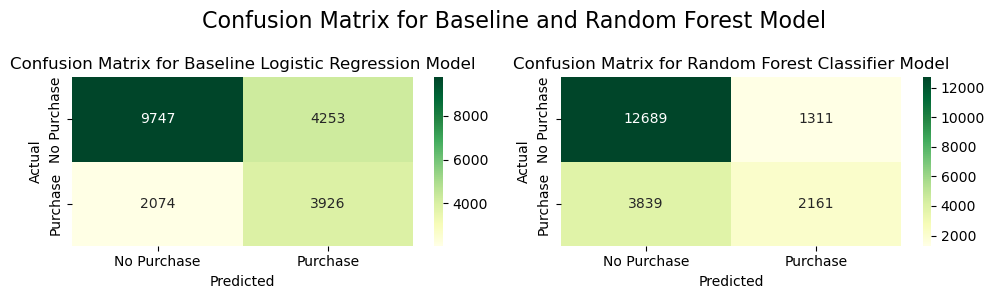

In [39]:
# Display the confusion matrix with labels
cm_logreg = confusion_matrix(y_val, y_pred_logreg)
cm_rf = confusion_matrix(y_val, y_pred_rf)
labels = ['No Purchase', 'Purchase']
plt.figure(figsize=(5, 4))

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
plt.suptitle('Confusion Matrix for Baseline and Random Forest Model', fontsize=16)
plt.subplot(1, 2, 1)
ax1 = sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='YlGn', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Baseline Logistic Regression Model')

plt.subplot(1, 2, 2)
ax1 = sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGn', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier Model')

plt.tight_layout()
plt.show()


In [ ]:
# Calculate and display the metrics at the class level
#Calculating Specificity
tn, fp, fn, tp = cm_logreg.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_logreg = {'Accuracy': [accuracy_score(y_val, y_pred_logreg), '', ''],
                  'Precision': ['', precision_score(y_val, y_pred_logreg, pos_label=0, zero_division=0), precision_score(y_val, y_pred_logreg, pos_label=1, zero_division=0)],
                  'Recall': ['', recall_score(y_val, y_pred_logreg, pos_label=0, zero_division=0), recall_score(y_val, y_pred_logreg, pos_label=1, zero_division=0)],
                  'Specificity': ['', specificity, ''],
                  'F1 Score': ['', f1_score(y_val, y_pred_logreg, pos_label=0, zero_division=0), f1_score(y_val, y_pred_logreg, pos_label=1, zero_division=0)],
                  'AUC': [roc_auc_score(y_val, y_proba_logreg), '', '']}

# Create a DataFrame for the metrics
metrics_df_logreg = pd.DataFrame(metrics_logreg, index=['Overall', 'No Purchase', 'Purchase'])

# Display the metrics DataFrame for the Baseline Logistic Regression and Random Forest Classification model
print("Metrics for Baseline Logistic Regression Model \n")
display(metrics_df_logreg)

#Calculating Specificity
tn, fp, fn, tp = cm_rf.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

metrics_rf = {'Accuracy': [accuracy_score(y_val, y_pred_rf), '', ''],
                  'Precision': ['', precision_score(y_val, y_pred_rf, pos_label=0, zero_division=0), precision_score(y_val, y_pred_rf, pos_label=1, zero_division=0)],
                  'Recall': ['', recall_score(y_val, y_pred_rf, pos_label=0, zero_division=0), recall_score(y_val, y_pred_rf, pos_label=1, zero_division=0)],
                  'Specificity': ['', specificity, ''],
                  'F1 Score': ['', f1_score(y_val, y_pred_rf, pos_label=0, zero_division=0), f1_score(y_val, y_pred_rf, pos_label=1, zero_division=0)],
                  'AUC': [roc_auc_score(y_val, y_proba_rf), '', '']}

# Create a DataFrame for the metrics
metrics_df_rf = pd.DataFrame(metrics_rf, index=['Overall', 'No Purchase', 'Purchase'])

print("Metrics for Random Forest Classification Model \n")
display(metrics_df_rf)


Metrics for Baseline Logistic Regression Model 



,Accuracy,Precision,Recall,Specificity,F1 Score,AUC
Overall,0.68365,,,,,0.738943
No Purchase,,0.82455,0.696214,0.696214,0.754967,
Purchase,,0.48001,0.654333,,0.553777,


Metrics for Random Forest Classification Model 



,Accuracy,Precision,Recall,Specificity,F1 Score,AUC
Overall,0.7425,,,,,0.739965
No Purchase,,0.767727,0.906357,0.906357,0.831302,
Purchase,,0.622408,0.360167,,0.456292,


## Model Comparison Table

| Model                | Accuracy | Precision (No Purchase)| Precision (Purchase) | Recall (No Purchase) | Recall (Purchase) | AUC    | Pros                    | Cons                      |
|----------------------|----------|------------------------|----------------------|----------------------|-------------------|--------|-------------------------|---------------------------|
| Logistic Regression  | 68.4%    | 82.45%                 | 48.00%               | 69.62%               | 65.43%            | 73.9%  | Interpretable           | Misses non-linear patterns|
| Random Forest        | 74.3%    | 76.77%                 | 62.24%               | 90.64%               | 36.02%            | 74.0%  | Handles non-linearity   | Harder to interpret       |

#### Based on the above table, Random Forest has higher overall accuracy (74.3% vs. 68.4%) and a slightly better AUC (74.0% vs. 73.9%), indicating it generally predicts better. However, it achieves this by prioritizing “No Purchase” predictions: its recall for “No Purchase” is very high (90.64%), but recall for “Purchase” is much lower (36.02%), meaning it misses many actual purchases. 
#### In contrast, Logistic Regression has a more balanced recall between classes (69.62% for “No Purchase” and 65.43% for “Purchase”), making it better at identifying purchasers.

### Recommendation:
	•	If the goal is to identify as many purchasers as possible (e.g., for targeted marketing), recommend Logistic Regression for its higher recall and precision on the “Purchase” class.
	•	If overall accuracy or correctly identifying non-purchasers is more important, Random Forest is preferable.

## In summary: 
    Choose Logistic Regression if capturing purchasers is critical; choose Random Forest for overall accuracy and identifying non-purchasers.

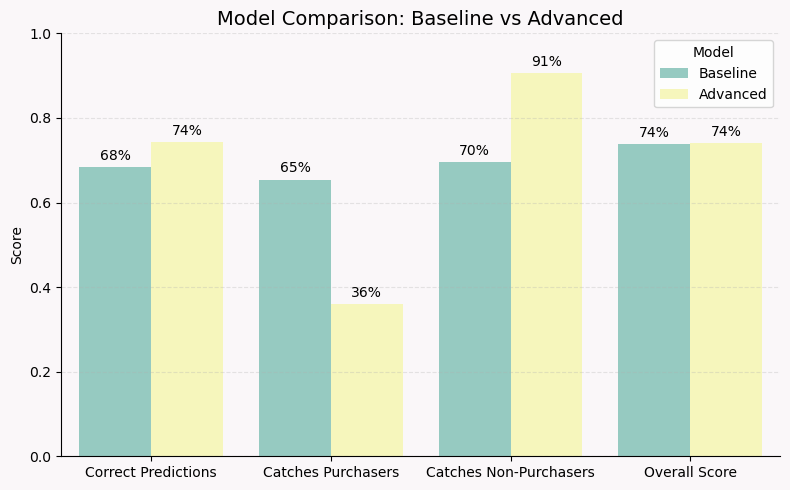

In [41]:
# Visual comparison of model metrics with no technical jargon and friendly labels)
# Prepare data for plotting
metrics_plot = pd.DataFrame({'Model': ['Baseline', 'Baseline', 'Baseline', 'Baseline', 'Advanced', 'Advanced', 'Advanced', 'Advanced'],
                             'Metric': ['Overall Accuracy', 'Finds Purchasers', 'Finds Non-Purchasers', 'Overall Score', 'Overall Accuracy', 'Finds Purchasers', 'Finds Non-Purchasers', 'Overall Score'],
                             'Value': [metrics_df_logreg.loc['Overall', 'Accuracy'],
                                       metrics_df_logreg.loc['Purchase', 'Recall'],
                                       metrics_df_logreg.loc['No Purchase', 'Recall'],
                                       metrics_df_logreg.loc['Overall', 'AUC'],
                                       metrics_df_rf.loc['Overall', 'Accuracy'],
                                       metrics_df_rf.loc['Purchase', 'Recall'],
                                       metrics_df_rf.loc['No Purchase', 'Recall'],
                                       metrics_df_rf.loc['Overall', 'AUC']]
                            })

# Friendly metric names
metric_labels = {'Overall Accuracy': 'Correct Predictions',
                 'Finds Purchasers': 'Catches Purchasers',
                 'Finds Non-Purchasers': 'Catches Non-Purchasers',
                 'Overall Score': 'Overall Score'}

metrics_plot['Metric'] = metrics_plot['Metric'].map(metric_labels)


# Plot
fig, ax = plt.subplots(figsize=(8, 5), facecolor='#faf7f9')
ax.set_facecolor("#faf7f9")

ax = sns.barplot(data=metrics_plot, x='Metric', y='Value', hue='Model', palette='Set3')
plt.ylim(0, 1)
plt.ylabel('Score')
plt.xlabel('')
plt.title('Model Comparison: Baseline vs Advanced', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Remove top and right spines (borders)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.0%}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()


In [ ]:
# print("Classification_report for Baseline Logistic Regression Model \n")
# print(classification_report(y_val, y_pred_rf, target_names=['No Purchase', 'Purchase'], zero_division=0))

# print("\nClassification_report for Random Forest Classifier Model \n")
# print(classification_report(y_val, y_pred_rf, target_names=['No Purchase', 'Purchase'], zero_division=0))


# Understanding Feature Importances 
#################### #################### #################### ####################  #################### #################### #################### #################### #################### ####################

In [43]:
# Display the most important features, as derived from a Random Forest model, in descending order of importance

# Create a DataFrame for feature importances
importances = pd.DataFrame({'Feature': X.columns,'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)

display(importances)


,Feature,Importance
4,PriorInterest_1,0.370233
7,Recency_Dormant,0.238300
6,Segment_C,0.165254
8,Recency_Inactive,0.106206
1,Age-Group_30-44,0.036934
5,Segment_B,0.035594
3,Age-Group_60+,0.033450
0,Age-Group_18-29,0.008210
2,Age-Group_45-59,0.005819


In [44]:
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(logreg, random_state=1).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())


Weight,Feature
0.0424 ± 0.0022,Recency_Dormant
0.0389 ± 0.0036,PriorInterest_1
0.0288 ± 0.0033,Recency_Inactive
0.0178 ± 0.0037,Segment_C
0.0110 ± 0.0043,Age-Group_30-44
0.0043 ± 0.0011,Age-Group_45-59
0.0033 ± 0.0019,Age-Group_18-29
0.0016 ± 0.0010,Age-Group_60+
-0.0000 ± 0.0015,Segment_B


In [ ]:
shap.initjs()


In [ ]:
# Compute SHAP values for the RandomForestClassifier
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_train)


In [56]:
# Compute SHAP values for the Logistic Regression model
logreg_explainer = shap.Explainer(logreg, X_train)
logreg_shap_values = logreg_explainer.shap_values(X_train)
# Get SHAP values for a specific instance (e.g., the 10th instance in the training set)
shap.plots.force(logreg_explainer.expected_value, logreg_shap_values[10, :], X_train.iloc[10, :])


In [48]:
# For SHAP v0.20+, use shap.plots.force and select the SHAP values for class 1 (positive class)
shap.plots.force(explainer.expected_value[1], shap_values[0, :, 1], X_train.iloc[10, :])


Both the plots show the SHAP values for 1 particular datapoint in the training data, i.e. the 10th datapoint (X_train.iloc[10, :]). However, in case of the first plot, the logistic regression model predcts a much larger negative value than the random forest classifier model (which actually has a positive value). In either case, as we are plotting for the Positive Class, the low baseline (and SHAP values) are understandable.

In addition, for the logistic regression model, 'Recency_Dormant'=1 has a negative effect, while for the random forest classifier model, 'Recency_Dormant'=1 has a positive effect. This is opposite for the 'Segemnt_C'=0 case. 
Also interestingly, 'Recency_Dormant'=1 has as much of a negative effect for the Logistic Rgeression model as 'Segment_C'=0 has for the Random Forest Classifier model.

### Interpreting the Two SHAP Force Plots for the Same Datapoint

The previous two SHAP force plots visualize how different features contribute to the model’s prediction for a single customer (datapoint), but each plot comes from a different model:

- **First plot:** SHAP force plot for the Logistic Regression model.
- **Second plot:** SHAP force plot for the Random Forest model.

#### What do these plots show?

- **Base Value:** The starting point (average model output) before considering any features.
- **Feature Contributions:** Each feature either pushes the prediction higher (towards purchase) or lower (towards no purchase), shown as colored arrows.
- **Final Prediction:** The sum of the base value and all feature contributions gives the model’s predicted probability for this customer.

#### Why are these plots significant?

- **Model Comparison:** By looking at both plots for the same customer, you can see how each model interprets the influence of features differently. For example, Random Forest may capture non-linear effects or interactions that Logistic Regression cannot.
- **Transparency:** SHAP force plots make it clear which features are driving the prediction for an individual, supporting explainability and trust in model decisions.
- **Actionable Insights:** If a feature (e.g., “PriorInterest_1”) strongly increases the likelihood of purchase, this insight can guide targeted marketing or interventions for similar customers.

#### In summary

- **Both plots explain the “why” behind a single prediction, but from different model perspectives.**
- **They help you understand which features matter most for a specific customer and how different models weigh those features.**
- **This is crucial for model validation, debugging, and communicating results to stakeholders.**

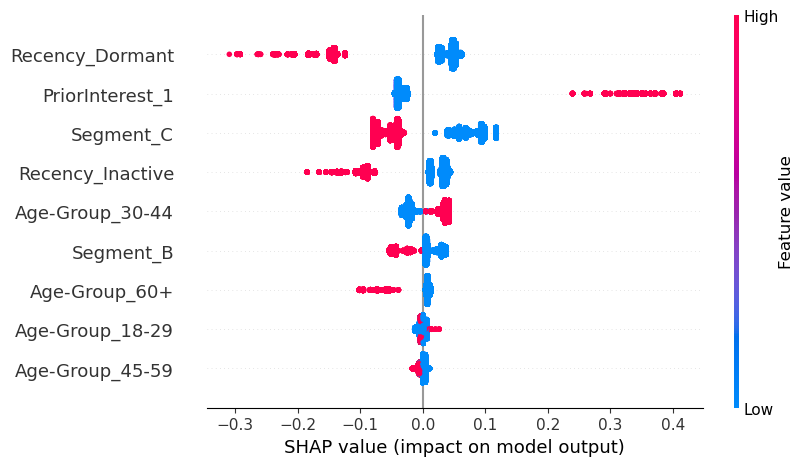

In [49]:
# For binary classification, use the SHAP values for the positive class (index 1)
shap_explanation = shap.Explanation(values=shap_values[:, :, 1], base_values=explainer.expected_value[1], data=X_train, feature_names=X_train.columns)
shap.plots.beeswarm(shap_explanation)


### The SHAP beeswarm plot above visualizes the impact of each feature on the model’s predictions for the positive class (purchase). 
 - Features are ranked by importance, with those at the top having the greatest influence. 
 - Each point represents a customer, colored by feature value, showing how high or low values push predictions higher or lower. 
 - For example, having prior interest or being in the "Dormant" recency group strongly affects the likelihood of purchase. 

### This plot helps identify which features drive the model’s decisions and how they interact.

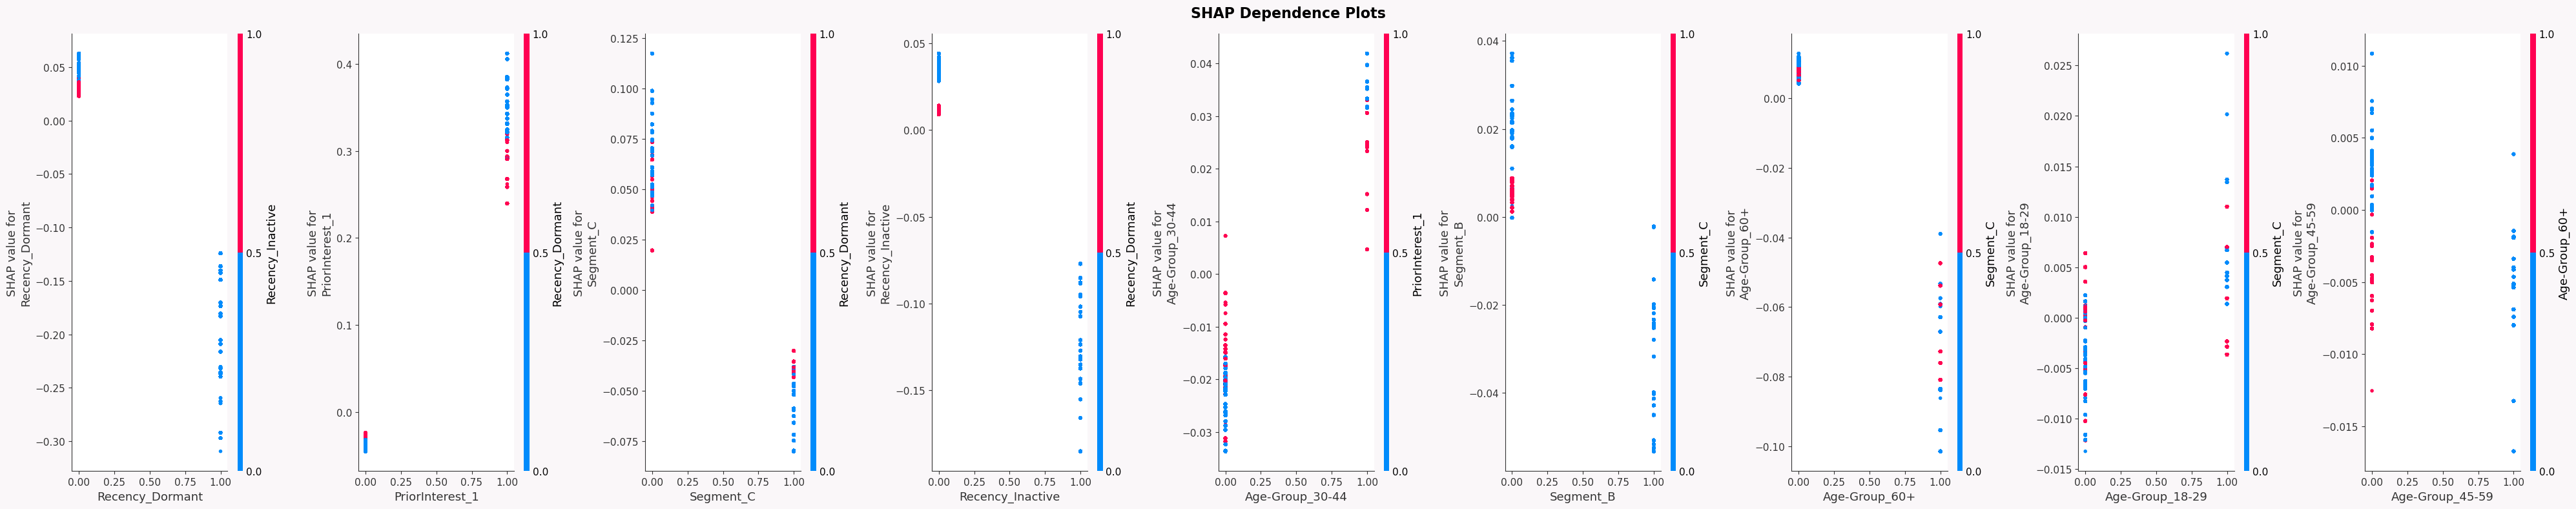

In [ ]:
features = ["Recency_Dormant","PriorInterest_1","Segment_C","Recency_Inactive","Age-Group_30-44","Segment_B","Age-Group_60+","Age-Group_18-29","Age-Group_45-59"]
fig, axes = plt.subplots(1, len(features), figsize=(40, 8), facecolor='#faf7f9')
ax.set_facecolor("#faf7f9")
fig.suptitle('SHAP Dependence Plots', fontsize=16, fontweight='bold', color='#000000')
fig.subplots_adjust(top=0.85)

for i, feature in enumerate(features):
    shap.dependence_plot(feature,
                         shap_values[:, :, 1],
                         X_train,
                         ax=axes[i],
                         show=False)

plt.tight_layout()
plt.show()


In [ ]:
# # Set the overall figure size for the two subplots
# plt.figure(figsize=(10, 5))    
# # Create 'Prior Interest' vs 'Did Purchase' plot
# ax1 = sns.countplot(data=data, x='PriorInterest', hue='DidPurchase', palette='Set1')
# plt.title('Prior Interest vs Did Purchase')
# plt.xticks(rotation=45)
# plt.xlabel('Prior Interest')
# plt.ylabel('Count')
# plt.legend(title='Did Purchase')
# # Annotate each bar in the Inyterest plot with its count
# for p in ax1.patches:
#     ax1.annotate(f'{int(p.get_height())}', 
#                     (p.get_x() + p.get_width() / 2., p.get_height()), 
#                     ha='center', va='center', 
#                     xytext=(0, 5), textcoords='offset points')        

# plt.show()    


In [ ]:
# # Sort segment_order in ascending order to ensure consistent subplot arrangement
# segment_order_sorted = sorted(segment_order)

# # Create a figure with subplots for each segment
# plt.figure(figsize=(12, 4))
# for i, segment in enumerate(segment_order_sorted):
#     plt.subplot(1, len(segment_order_sorted), i + 1)
#     # For the current segment, get counts of each recency value, sorted descending
#     recency_counts = data[data['Segment'] == segment]['Recency'].value_counts().sort_values(ascending=False)
#     recency_order_segment = recency_counts.index.tolist()
#     # Plot the count of each recency value for the current segment
#     ax = sns.countplot(
#         data=data[data['Segment'] == segment],
#         x='Recency',
#         order=recency_order_segment
#     )
#     plt.title(f"Segment: {segment}")
#     plt.xlabel('Recency')
#     plt.ylabel('Count')
#     plt.xticks(rotation=45)
#     # Annotate each bar with its count value
#     for p in ax.patches:
#         ax.annotate(f'{int(p.get_height())}', 
#                     (p.get_x() + p.get_width() / 2., p.get_height()), 
#                     ha='center', va='center', 
#                     xytext=(0, 5), textcoords='offset points')
# # Adjust layout to prevent overlap between subplots
# plt.tight_layout()
# plt.show()
